In [40]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

Load data

In [41]:
data = pd.read_csv(r'C:\Users\samuel\dsmp-2024-group18\Data Clean\data\data_combine\data_kdj_macd\data_kdj_macd.csv')

#data.set_index('Datetime', inplace=True)
print(data.head())

   Unnamed: 0        DateTime_Hour  Bid1_Price  Bid1_Volume  Ask1_Price  \
0           0  2025-01-02 07:00:00      260.80      68151.0      272.70   
1           1  2025-01-02 08:00:00      260.59     149055.0      276.85   
2           2  2025-01-02 09:00:00      270.72     173924.0      281.03   
3           3  2025-01-02 10:00:00      285.52     189539.0      292.01   
4           4  2025-01-02 11:00:00      290.77     161596.0      298.17   

   Ask1_Volume  Bid2_Price  Bid2_Volume  Ask2_Price  Ask2_Volume  ...  \
0      47626.0      255.35      75283.0      298.01      49250.0  ...   
1      91202.0      256.43     162582.0      314.94      95695.0  ...   
2     116893.0      266.14     193618.0      308.89     121499.0  ...   
3     127378.0      282.14     205334.0      301.17     142418.0  ...   
4     114841.0      287.22     176047.0      308.88     122278.0  ...   

   Trade_Price_Min  Trade_Price_Max  Trade_Volume  Trade_Price_Mean  MACD_DIF  \
0            249.0           

In [72]:
# Initial conditions
initial_cash = 10000  # Starting cash
cash = initial_cash
shares_owned = 0  # Starting shares owned
transactions = []  # List to record transactions

# Parameters for market impact, slippage, and fees
market_impact_constant = 0.1
average_daily_volume = data['Trade_Volume'].count() # Using total count as a proxy
brokerage_fee_bps = 0.50 / 100
exchange_fee_per_share = 0.000025
shares_per_transaction = 200

# Thresholds
bid_ask_spread_threshold = data['Bid_Ask_Spread'].quantile(0.5)  # Liquidity - median spread as threshold 
order_imbalance_threshold = 0.10  # Volume - laceholder value

# if moving average then define the window size for the moving average
sma_window_size = 10
# Calculate the SMA for Mid-Price
data['SMA_Mid_Price'] = data['Mid-Price'].rolling(window=sma_window_size).mean()

# Holding Threshilds
volatility_threshold = 0.05  # Placeholder for volatility threshold
proximity_threshold = 0.02  # Placeholder for how close the price should be to the SMA to consider holding

# Adjusted trading signal logic incorporating the suggested changes
for i in range(sma_window_size, len(data)):
    k = data.iloc[i]['K']
    d = data.iloc[i]['D']
    j = data.iloc[i]['J']
    dif = data.iloc[i]['MACD_DIF']
    dea = data.iloc[i]['MACD_DEA']
    
    # Adjusted buy and sell signals based on the new criteria
    buy_signal = j < 40 and dif > dea
    sell_signal = j > 60 and dif < dea
    
    current_mid_price = data.iloc[i]['Mid-Price']
    average_mid_price = data.iloc[i]['SMA_Mid_Price']
    is_liquid = data.iloc[i]['Bid_Ask_Spread'] <= bid_ask_spread_threshold and abs(data.iloc[i]['Order_imbalance']) <= order_imbalance_threshold

    if buy_signal and current_mid_price > average_mid_price:
        shares_to_buy = min(shares_per_transaction, int(cash / (current_mid_price + brokerage_fee_bps * current_mid_price + exchange_fee_per_share)))
        if shares_to_buy > 0:
            volume_ratio = shares_to_buy / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_buy_price = current_mid_price + price_impact
            total_cost = adjusted_buy_price * shares_to_buy + brokerage_fee_bps * adjusted_buy_price * shares_to_buy + exchange_fee_per_share * shares_to_buy
            cash -= total_cost
            shares_owned += shares_to_buy
            transactions.append(('Buy', shares_to_buy, adjusted_buy_price, total_cost, cash, i))
    
    elif sell_signal and current_mid_price < average_mid_price and shares_owned > 0:
        shares_to_sell = min(shares_owned, shares_per_transaction)
        if shares_to_sell > 0:
            volume_ratio = shares_to_sell / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_sell_price = current_mid_price - price_impact
            total_revenue = adjusted_sell_price * shares_to_sell - brokerage_fee_bps * adjusted_sell_price * shares_to_sell - exchange_fee_per_share * shares_to_sell
            cash += total_revenue
            transactions.append(('Sell', shares_to_sell, adjusted_sell_price, total_revenue, cash, i))
            shares_owned -= shares_to_sell

# Calculate the final valuation again
final_valuation_adjusted = cash + shares_owned * data.iloc[-1]['Mid-Price']

# Update the output dictionary
output_final_adjusted = {
    "Initial Cash": initial_cash,
    "Final Valuation": final_valuation_adjusted,
    "Overall Profit/Loss": final_valuation_adjusted - initial_cash,
    "Number of Transactions": len(transactions),
    "First 5 Transactions": transactions[:5],
    "shares_owned": shares_owned
}

output_final_adjusted



{'Initial Cash': 10000,
 'Final Valuation': 5539.858846456495,
 'Overall Profit/Loss': -4460.141153543505,
 'Number of Transactions': 6,
 'First 5 Transactions': [('Buy',
   32,
   306.9611827054668,
   9871.872435807813,
   128.1275641921875,
   13),
  ('Sell', 32, 289.149693425962, 9206.525438682631, 9334.653002874818, 143),
  ('Buy', 26, 361.22929626345035, 9438.922161363957, -104.26915848913814, 168),
  ('Sell', 26, 309.73856033730425, 8012.935905926061, 7908.666747436923, 186),
  ('Buy', 24, 322.61424910959784, 7781.4562885235, 127.21045891342328, 353)],
 'shares_owned': 0}

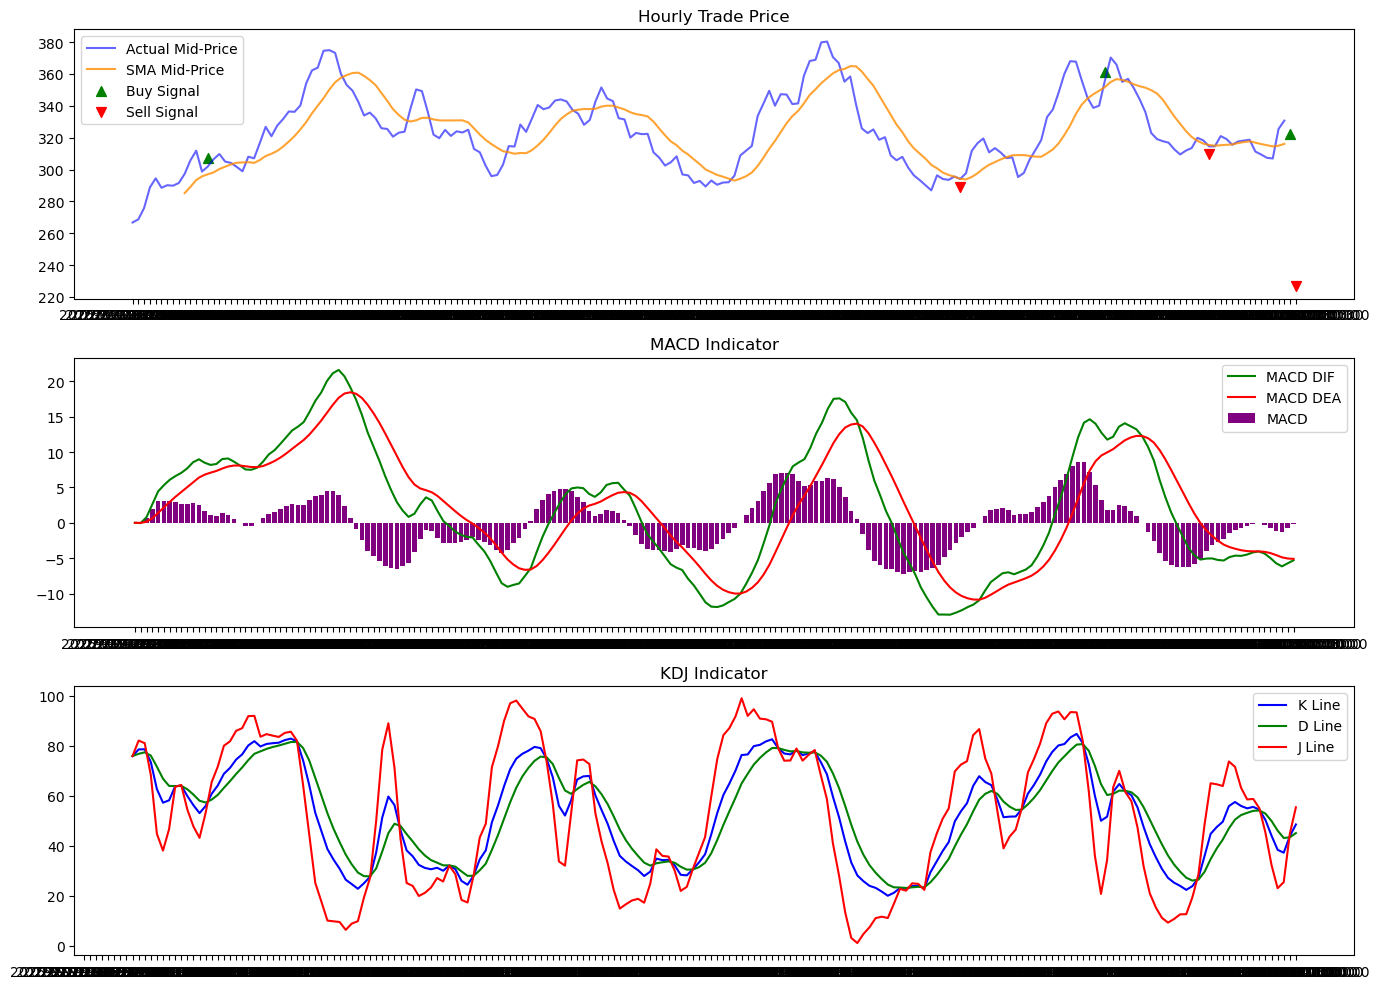

In [74]:
import matplotlib.pyplot as plt

transactions_df = pd.DataFrame(transactions, columns=['Action', 'Shares', 'Price', 'Total Cost', 'Cash After', 'Time'])
# 'Time' in transactions was an index in transactions so map it to a Datetime
transactions_df['Datetime'] = transactions_df['Time'].apply(lambda x: data.iloc[x]['DateTime_Hour'])

# 设置绘图大小
plt.figure(figsize=(14, 10))
# 绘制MACD指标相关线
plt.subplot(311)
plt.plot(data['DateTime_Hour'][:200], data['Mid-Price'][:200], label='Actual Mid-Price', color='blue', alpha=0.6)
plt.plot(data['DateTime_Hour'][:200], data['SMA_Mid_Price'][:200], label='SMA Mid-Price', color='darkorange', alpha=0.8)
plt.title('Hourly Trade Price')
buy_signals = transactions_df[transactions_df['Action'] == 'Buy']
sell_signals = transactions_df[transactions_df['Action'] == 'Sell']
plt.scatter(buy_signals['Datetime'][:200], buy_signals['Price'], label='Buy Signal', color='green', marker='^', s=50, alpha=1.0)
plt.scatter(sell_signals['Datetime'][:200], sell_signals['Price'], label='Sell Signal', color='red', marker='v', s=50, alpha=1.0)
plt.legend()

plt.subplot(312)
plt.plot(data['DateTime_Hour'][:200], data['MACD_DIF'][:200], label='MACD DIF', color='green')
plt.plot(data['DateTime_Hour'][:200], data['MACD_DEA'][:200], label='MACD DEA', color='red')
plt.bar(data['DateTime_Hour'][:200], data['MACD'][:200], label='MACD', color='purple')
plt.title('MACD Indicator')
plt.legend()

plt.subplot(313)
plt.plot(data['DateTime_Hour'][:200], data['K'][:200], label='K Line', color='blue')
plt.plot(data['DateTime_Hour'][:200], data['D'][:200], label='D Line', color='green')
plt.plot(data['DateTime_Hour'][:200], data['J'][:200], label='J Line', color='red')
plt.title('KDJ Indicator')
plt.legend()

plt.tight_layout()
plt.show()

Run Simulation

KeyError: 'Datetime'

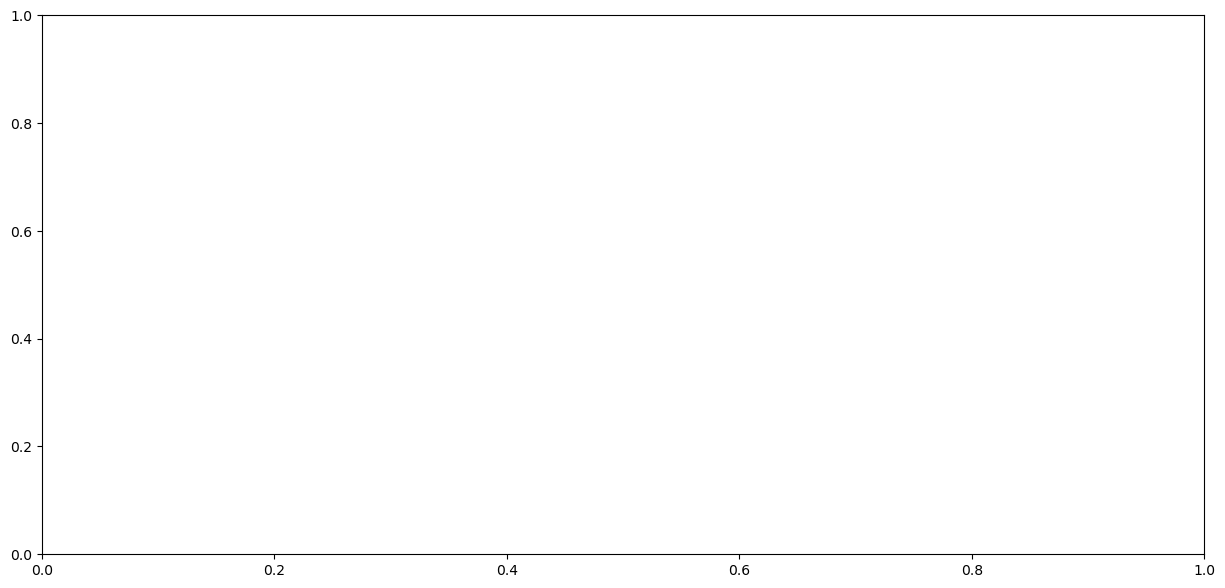

In [67]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert transactions to a df
transactions_df = pd.DataFrame(transactions, columns=['Action', 'Shares', 'Price', 'Total Cost', 'Cash After', 'Time'])
# 'Time' in transactions was an index in transactions so map it to a Datetime
transactions_df['Datetime'] = transactions_df['Time'].apply(lambda x: data.iloc[x]['Datetime'])

# plot
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(data['Datetime'], data['Mid-Price'], label='Actual Mid-Price', color='blue', alpha=0.6)
ax.plot(data['Datetime'], data['SMA_Mid_Price'], label='SMA Mid-Price', color='darkorange', alpha=0.8)

# add buy and sell signals
buy_signals = transactions_df[transactions_df['Action'] == 'Buy']
sell_signals = transactions_df[transactions_df['Action'] == 'Sell']
ax.scatter(buy_signals['Datetime'], buy_signals['Price'], label='Buy Signal', color='green', marker='^', s=50, alpha=1.0)
ax.scatter(sell_signals['Datetime'], sell_signals['Price'], label='Sell Signal', color='red', marker='v', s=50, alpha=1.0)

# format the x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# Add labels with model results
final_valuation = final_valuation_corrected  # From the previous output
text_str = f'Initial Cash: ${initial_cash:.1f}\nFinal Valuation: ${final_valuation:.1f}\nOverall Profit/Loss: ${final_valuation - initial_cash:.1f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# Position the text on the axes (adjust the x and y values based on your plot's layout)
ax.text(0.01, 0.97, text_str, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_title('Trading Simulation with Buy and Sell Signals', fontsize=15)
ax.set_xlabel('Time')
ax.set_ylabel('Mid-Price ($)')
ax.legend(loc='lower right', fontsize=11)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()


Export the figure

In [20]:
fig.savefig('Trading Simulation ARIMA1 Results Rolling.png', dpi=600, bbox_inches='tight')

In [28]:
def run_trading_simulation(sma_window_size, bid_ask_spread_threshold, order_imbalance_threshold, volatility_threshold, proximity_threshold):
    # Initial conditions
    initial_cash = 10000  # Starting cash
    cash = initial_cash
    shares_owned = 0  # Starting shares owned
    transactions = []  # List to record transactions
    # Parameters for market impact, slippage, and fees
    market_impact_constant = 0.1
    average_daily_volume = data['Mid-Price'].count()  # Using total count as a proxy
    brokerage_fee_bps = 0.50 / 100
    exchange_fee_per_share = 0.000025
    shares_per_transaction = 500
  
    data['SMA_Mid_Price'] = data['Mid-Price'].rolling(window=sma_window_size).mean()

    # Trading simulation loop (buy, sell, hold logic)
    # Run simulation
    for i in range(sma_window_size, len(data)):
        current_mid_price = data.iloc[i]['Mid-Price']
        average_mid_price = data.iloc[i]['SMA_Mid_Price']
        order_imbalance = data.iloc[i]['Order_imbalance']
        bid_ask_spread = data.iloc[i]['Bid_Ask_Spread']  # Use the actual column for bid-ask spread
        is_liquid = bid_ask_spread <= bid_ask_spread_threshold and abs(order_imbalance) <= order_imbalance_threshold
        price_proximity = abs(current_mid_price - average_mid_price) / average_mid_price
        volatility = data.iloc[i]['Historical_Volatility']
        is_hold_condition = (price_proximity < proximity_threshold or volatility > volatility_threshold)

        # Buy condition
        if current_mid_price < average_mid_price and is_liquid:
            shares_to_buy = min(shares_per_transaction, int(cash / (current_mid_price + brokerage_fee_bps * current_mid_price + exchange_fee_per_share)))
            if shares_to_buy > 0:
                volume_ratio = shares_to_buy / average_daily_volume
                price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
                adjusted_buy_price = current_mid_price + price_impact
                total_cost = adjusted_buy_price * shares_to_buy + brokerage_fee_bps * adjusted_buy_price * shares_to_buy + exchange_fee_per_share * shares_to_buy
                cash -= total_cost
                shares_owned += shares_to_buy
                transactions.append(('Buy', shares_to_buy, adjusted_buy_price, total_cost, cash, i))
        
        # Sell condition
        elif current_mid_price > average_mid_price and is_liquid and shares_owned > 0:
            volume_ratio = shares_owned / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_sell_price = current_mid_price - price_impact
            total_revenue = adjusted_sell_price * shares_owned - brokerage_fee_bps * adjusted_sell_price * shares_owned - exchange_fee_per_share * shares_owned
            cash += total_revenue
            transactions.append(('Sell', shares_owned, adjusted_sell_price, total_revenue, cash, i))
            shares_owned = 0

        # Hold condition
        elif is_hold_condition:
            # Log hold action only if conditions suggest increased risk or uncertainty
            transactions.append(('Hold', shares_owned, current_mid_price, 0, cash, i))

    # Return the overall profit or loss for this simulation run
    final_valuation = cash + shares_owned * data.iloc[-1]['Mid-Price']
    return final_valuation - initial_cash, transactions
    

# Parameter ranges (example ranges, adjust as needed)
sma_window_sizes = [10, 15, 20, 40]
bid_ask_thresholds = [int(data['Bid_Ask_Spread'].quantile(0.4)), int(data['Bid_Ask_Spread'].quantile(0.5)), int(data['Bid_Ask_Spread'].quantile(0.6))]
order_imbalance_thresholds = [0, 0.1, 0.5, 0.1]
volatility_thresholds = [0, 0.1, 0.5, 1]
proximity_thresholds = [0, 0.1, 0.5, 1]

results = []

# Iterating over all combinations of parameters
for sma_size in sma_window_sizes:
    for bid_ask_thresh in bid_ask_thresholds:
        for order_imbalance_thresh in order_imbalance_thresholds:
            for volatility_thresh in volatility_thresholds:
                for proximity_thresh in proximity_thresholds:
                    profit_loss, transactions = run_trading_simulation(sma_size, bid_ask_thresh, order_imbalance_thresh, volatility_thresh, proximity_thresh)
                    results.append((sma_size, bid_ask_thresh, order_imbalance_thresh, volatility_thresh, proximity_thresh, profit_loss, len(transactions)))


# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results, columns=['SMA Size', 'Bid-Ask Thresh', 'Order Imbalance Thresh', 'Volatility Thresh', 'Proximity Thresh', 'Profit/Loss', 'Number of Transactions'])
print(results_df.head(50))
results_df.to_csv('Threshold Test Results.csv')

[('Hold', 0, 268.0185, 0, 10000, 10), ('Hold', 0, 266.12933333333336, 0, 10000, 11), ('Hold', 0, 264.37233333333336, 0, 10000, 12), ('Hold', 0, 259.6859090909091, 0, 10000, 13), ('Hold', 0, 258.15190476190475, 0, 10000, 14), ('Hold', 0, 281.05263157894734, 0, 10000, 15), ('Hold', 0, 266.18806451612903, 0, 10000, 16), ('Hold', 0, 281.51906976744186, 0, 10000, 17), ('Hold', 0, 269.3552941176471, 0, 10000, 18), ('Hold', 0, 269.2739285714286, 0, 10000, 19), ('Hold', 0, 268.8994, 0, 10000, 20), ('Hold', 0, 266.35243902439026, 0, 10000, 21), ('Hold', 0, 261.89418604651166, 0, 10000, 22), ('Hold', 0, 281.0727659574468, 0, 10000, 23), ('Hold', 0, 268.5988372093023, 0, 10000, 24), ('Hold', 0, 284.1487096774194, 0, 10000, 25), ('Hold', 0, 265.11977272727273, 0, 10000, 26), ('Hold', 0, 260.8870833333333, 0, 10000, 27), ('Hold', 0, 255.80846153846156, 0, 10000, 28), ('Hold', 0, 268.61625, 0, 10000, 29), ('Hold', 0, 259.28578947368425, 0, 10000, 30), ('Hold', 0, 266.3261016949152, 0, 10000, 31), ('

KeyboardInterrupt: 

TypeError: unhashable type: 'numpy.ndarray'

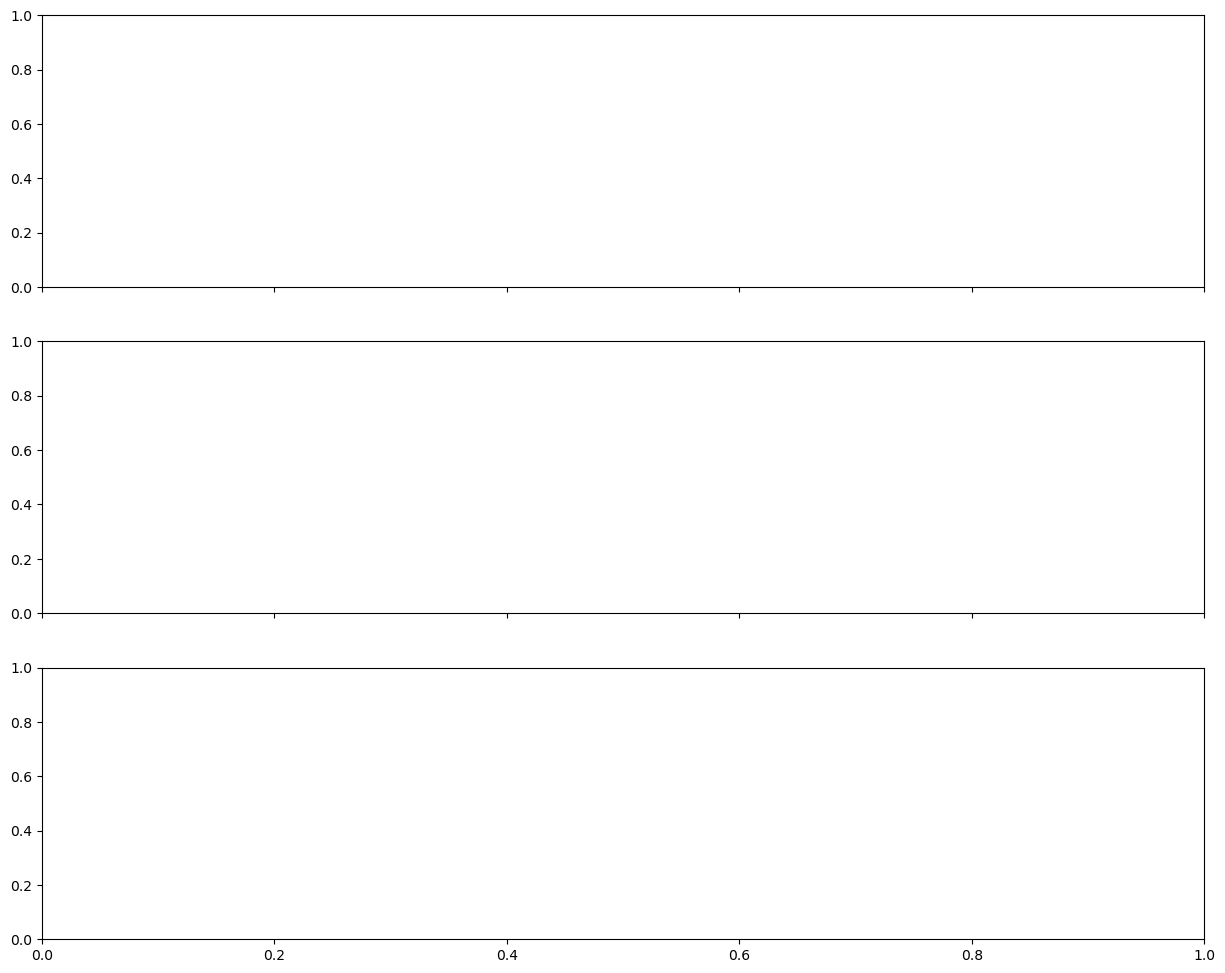

In [50]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 假设数据已经准备好，包含DateTime_Hour, Mid-Price, MACD_DIF, MACD_DEA, K, D, J
# 并且transactions_df已经包含交易数据

fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# 第一个图表：价格和SMA
axs[0].plot(data['DateTime_Hour'][:200], data['Mid-Price'][:200], label='Mid-Price', color='blue')
axs[0].plot(data['DateTime_Hour'][:200], data['SMA_Mid_Price'][:200], label='SMA Mid-Price', color='orange')
axs[0].set_ylabel('Price')
axs[0].legend(loc='upper left')
axs[0].set_title('Price and SMA')

# 第二个图表：MACD
axs[1].plot(data['DateTime_Hour'][:200], data['MACD_DIF'][:200], label='MACD DIF', color='red')
axs[1].plot(data['DateTime_Hour'][:200], data['MACD_DEA'][:200], label='MACD DEA', color='green')
axs[1].fill_between(data['DateTime_Hour'][:200], data['MACD_DIF'][:200], data['MACD_DEA'][:200], where=(data['MACD_DIF'][:200] > data['MACD_DEA'][:200]), facecolor='red', alpha=0.3, interpolate=True)
axs[1].fill_between(data['DateTime_Hour'][:200], data['MACD_DIF'][:200], data['MACD_DEA'][:200], where=(data['MACD_DIF'][:200] <= data['MACD_DEA'][:200]), facecolor='green', alpha=0.3, interpolate=True)
axs[1].set_ylabel('MACD')
axs[1].legend(loc='upper left')
axs[1].set_title('MACD Indicator')

# 第三个图表：KDJ
axs[2].plot(data['DateTime_Hour'][:200], data['K'][:200], label='K', color='blue')
axs[2].plot(data['DateTime_Hour'][:200], data['D'][:200], label='D', color='orange')
axs[2].plot(data['DateTime_Hour'][:200], data['J'][:200], label='J', color='purple')
axs[2].set_ylabel('KDJ')
axs[2].legend(loc='upper left')
axs[2].set_title('KDJ Indicator')

# 设置x轴为日期时间格式
for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)

# 调整布局
plt.tight_layout()
plt.show()
